<a href="https://colab.research.google.com/github/thepianist9/SmartCab/blob/main/Cab_Simulation(Q_learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gym
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

#for text processing
from nltk.tokenize import word_tokenize as tk
import re
import pandas as pd
env = gym.make("Taxi-v3").env

env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [2]:
city_df = pd.read_csv("https://raw.githubusercontent.com/thepianist9/SmartCab/0744b813d851a7d61156a44c6a23e2de85a99a63/city.csv")
all_cities = city_df['location'].tolist()
print("Locations:")
all_cities

Locations:


['dwarka sector 23', 'dwarka sector 21', 'hauz khaas', 'airport']

#### There are 4 locations (labeled by different letters), the program picks up the passenger at one location and drops him off at another. We receive +20 points for a successful drop-off and lose 1 point for every time-step it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions."

### Fetching Pickup, Destination, and Time information from the sms data.

In [3]:
env.reset() # reset environment to a new, random state
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


In [5]:
#Initialize Q_table
import numpy as np

state = env.encode(4, 1, 2, 3) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)
env.s = state
env.render()


State: 431
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [6]:
q_table = np.zeros([env.observation_space.n, env.action_space.n])

#Sample Sms text:


In [7]:
sms = pd.read_csv('https://raw.githubusercontent.com/thepianist9/SmartCab/main/sms.txt', names = ['text'])
sms.iloc[2]['text']

'Kindly book a cab for me at 1 PM from hauz khaas to dwarka sector 23'

#Q-Learning Formula:

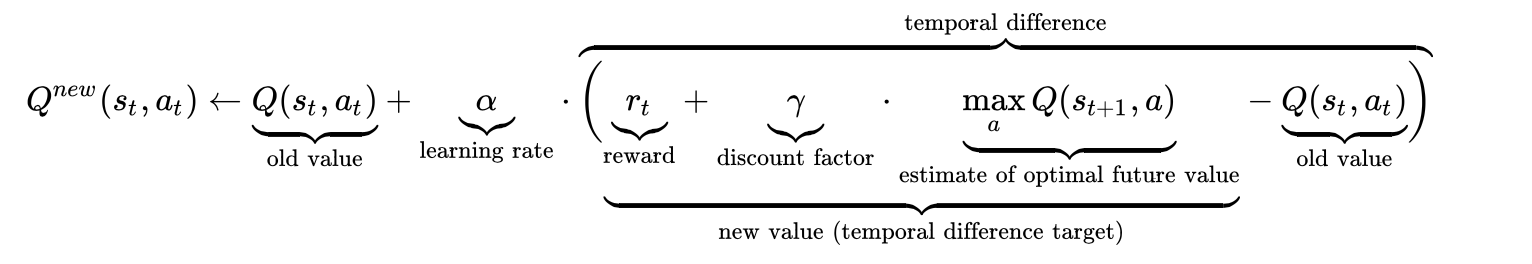

In [8]:
%%time
import random
from IPython.display import clear_output

# Create Hyperparameters for our Q-learning algorithm
total_epochs = 50000           
total_test_episodes = 100       
max_steps = 99                   

learning_rate = 0.7              
gamma = 0.610                      
alpha = 0.3
# Exploration parameters
epsilon = 1.0                   
max_epsilon = 1.0                
min_epsilon = 0.01               
decay_rate = 0.01              

CPU times: user 12 µs, sys: 3 µs, total: 15 µs
Wall time: 18.6 µs


## Training and Exploiting learned values
After enough random exploration of actions, the Q-values tend to converge serving our agent as an action-value function which it can exploit to pick the most optimal action from a given state.

In [9]:
"""Training the agent"""
for epoch in range(total_epochs):
    # Reset environment
    state = env.reset()
    step = 0 
    done = False
    
    for step in range(max_steps):
        # choose an action in the current state space
        exp_expl_tradeoff = random.uniform(0,1)

        if exp_expl_tradeoff > epsilon:
            action = np.argmax(q_table[state,:])
        # else start exploration:
        else:
            action = env.action_space.sample()
            
        new_state, reward, done, info = env.step(action) #run one timestep 
        
        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        q_table[state, action] = q_table[state, action] + learning_rate * (reward + gamma * 
                                    np.max(q_table[new_state, :]) - q_table[state, action])
        state = new_state

        if done == True:
            break
        
    epoch += 1
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*epoch)#1+e^(-0.01*1)


np.save("./q_table.npy", q_table)

In [10]:
q_table = np.load("./q_table.npy")

In [11]:
def create_loc_dict(city_df):
    loc_dict = {'dwarka sector 23': 0, 'dwarka sector 21': 1, 'hauz khaas':2, 'airport':3}   
    return loc_dict

In [12]:
orig_df = pd.read_csv(r"https://raw.githubusercontent.com/thepianist9/SmartCab/main/org_df.csv") 
def check_pick_up_drop_correction(pick_up, drop, line_num):
    org_list = orig_df.iloc[line_num].tolist()
    original_origin = org_list[0]
    original_destination = org_list[1]
    if original_origin == pick_up and original_destination == drop:
        return True
    else:
        return False

    

In [18]:
# Evaluate agent's performance after Q-learning

total_epochs, total_penalties,wrong_predictions = 0, 0, 0
total_reward = []


count = 0
time_list = []
f = open("/content/sms.txt", "r")
num_of_lines = 1000
episode = 0

loc_dict = {'dwarka sector 23': 0, 'dwarka sector 21': 1, 'hauz khaas':2, 'airport':3}
line_num = 0
rewards = 0
frames=[]
for line in f:
    done = False
    pickup, drop, time = fetch_pickup_drop(line)
    rewards = 0
    state = env.reset()
    state = env.encode(random.randint(0,4), random.randint(0,4) , loc_dict[pickup], loc_dict[drop]) # (taxi row, taxi column, passenger index, destination index)
    env.s = state
    
    
    for step in range(200):
        action = np.argmax(q_table[state,:])
        
        new_state, reward, done, info = env.step(action)
        
        rewards += reward
        state = new_state
        
        frames.append({
        'episode': episode,
        'origin': pickup,
        'destination': drop,
        'frame': env.render(mode='ansi'),
        'state': new_state,
        'action': action,
        'reward': reward
        }
        )
        
        if done:
            total_reward.append(rewards)
            total_epochs += step
            break
    if (check_pick_up_drop_correction(pickup, drop, line_num)):
        pass
    else:
        total_penalties+=1
        wrong_predictions+=1
        total_reward[line_num] -= 10
        
    
    line_num+=1
    episode+=1
     
    
total_rewards = 0
for i in total_reward:
    total_rewards += i
total_rewards = total_rewards/num_of_lines


print(f"Results after {num_of_lines} episodes:")
print(f"Average timesteps per episode: {total_epochs / num_of_lines}")
print(f"Average penalties per episode: {total_penalties / num_of_lines}")
print(f"Total number of wrong predictions", wrong_predictions)
print()
print("Total Reward is", total_rewards)

Results after 1000 episodes:
Average timesteps per episode: 12.13
Average penalties per episode: 0.0
Total number of wrong predictions 0

Total Reward is 7.87


In [16]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    print(frames)
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Episode: {frame['episode']}, origin: {frame['origin']}, destination: {frame['destination']}")
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(0.01)
        
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Episode: 999, origin: airport, destination: hauz khaas
Timestep: 13115
State: 410
Action: 5
Reward: 20
